In [17]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection
import pandas as pd
from dotenv import load_dotenv

In [19]:
load_dotenv()
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [20]:
config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

Fetching...
Success!


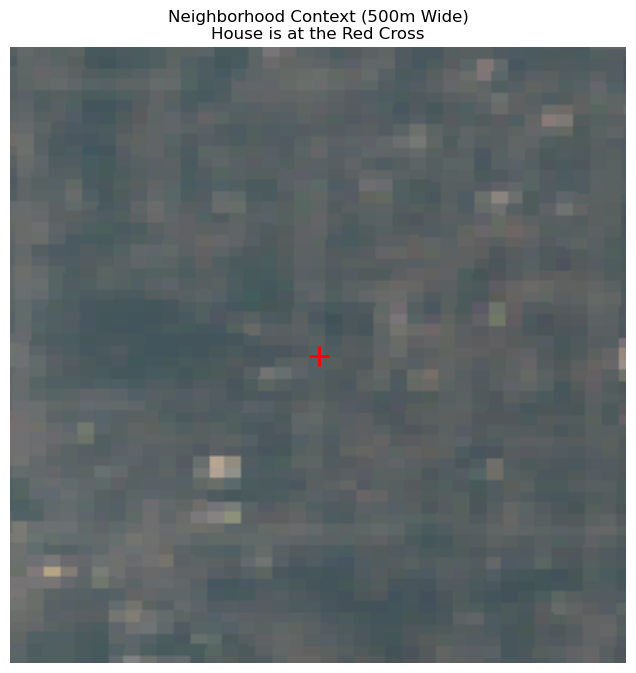

In [22]:
# example run 
lat, long = 47.5112, -122.257
offset = 0.0025 
coords_wgs84 = [long - offset, lat - offset, long + offset, lat + offset]
house_bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

request = SentinelHubRequest(
    data_folder='test_images',
    evalscript="""
        // Return Red, Green, Blue
        return [B04, B03, B02];
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A, 
            time_interval=('2023-06-01', '2023-08-30'),   
            maxcc=0.1
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=house_bbox,
    size=(256, 256),
    config=config
)

print("Fetching...")
try:
    response = request.get_data()
    
    if len(response) > 0:
        image_data = response[0]

        # Normalize and Brighten
        image_data = image_data.astype(np.float32) / 255.0
        image_data = np.clip(image_data * 2.5, 0.0, 1.0)

        print("Success!")
        plt.figure(figsize=(8, 8))
        # interpolation='bilinear' smooths the pixels slightly for a nicer look
        plt.imshow(image_data, interpolation='bilinear')
        
        # Draw a small red box in the center to show where the house is
        plt.plot(128, 128, 'r+', markersize=15, markeredgewidth=2)
        
        plt.title(f"Neighborhood Context (500m Wide)\nHouse is at the Red Cross")
        plt.axis('off')
        plt.show()
    else:
        print("No image found.")

except Exception as e:
    print(f"Error: {e}")

In [ ]:
IMAGE_DIR = "images_satellite"                
NUM_TO_DOWNLOAD = 10000                       

# Loading Data
df = pd.read_csv('train.csv')
subset_df = df.head(NUM_TO_DOWNLOAD)

if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# download function
def download_house_image(house_id, lat, long):
    if os.path.exists(f"{IMAGE_DIR}/{house_id}.png"):
        return "Exists"
    
    offset = 0.0025 

    bbox = BBox(bbox=[long - offset, lat - offset, long + offset, lat + offset], crs=CRS.WGS84)

    request = SentinelHubRequest(
        evalscript="return [B04, B03, B02];", 
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2023-06-01', '2023-08-30'),
                maxcc=0.1
            )
        ],
        responses=[SentinelHubRequest.output_response('default', MimeType.PNG)],
        bbox=bbox,
        size=(224, 224), 
        config=config
    )

    try:
        response = request.get_data()
        if len(response) > 0:
            img_array = response[0]
            img_array = img_array.astype(np.float32) / 255.0
            img_array = np.clip(img_array * 2.5, 0.0, 1.0)
            img_uint8 = (img_array * 255).astype(np.uint8)
            plt.imsave(f"{IMAGE_DIR}/{house_id}.png", img_uint8)
            return "Success"
        else:
            return "No Data"
    except Exception as e:
        return f"Error: {e}"

In [ ]:
#downloading images
print(f"Starting download for {NUM_TO_DOWNLOAD} houses...")
print(f"Saving to folder: {IMAGE_DIR}")

success_count = 0
start_time = time.time()

for index, row in subset_df.iterrows():
    status = download_house_image(row['id'], row['lat'], row['long'])

    if status == "Success":
        success_count += 1
        if success_count % 10 == 0:
            print(f"Downloaded {success_count}/{NUM_TO_DOWNLOAD}...")
    elif status == "Exists":
        pass 
    else:
        print(f"Failed {row['id']}: {status}")
    time.sleep(0.1)

print(f"Batch Download Complete!")
print(f"Successfully saved {success_count} images.")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes.")

Starting download for 10000 houses (Offset 0.0025)...
Saving to folder: images_satellite/
Downloaded 10/10000...
Downloaded 20/10000...
Downloaded 30/10000...
Downloaded 40/10000...
Downloaded 50/10000...
Downloaded 60/10000...
Downloaded 70/10000...
Downloaded 80/10000...
Downloaded 90/10000...
Downloaded 100/10000...
Downloaded 110/10000...
Downloaded 120/10000...
Downloaded 130/10000...
Downloaded 140/10000...
Downloaded 150/10000...
Downloaded 160/10000...
Downloaded 170/10000...
Downloaded 180/10000...
Downloaded 190/10000...
Downloaded 200/10000...
Downloaded 210/10000...
Downloaded 220/10000...
Downloaded 230/10000...
Downloaded 240/10000...
Downloaded 250/10000...
Downloaded 260/10000...
Downloaded 270/10000...
Downloaded 280/10000...
Downloaded 290/10000...
Downloaded 300/10000...
Downloaded 310/10000...
Downloaded 320/10000...
Downloaded 330/10000...
Downloaded 340/10000...
Downloaded 350/10000...
Downloaded 360/10000...
Downloaded 370/10000...
Downloaded 380/10000...
Downloa